In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import collections
from tqdm import tqdm
from tensor2tensor.utils import beam_search
sns.set()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-pa

In [2]:
with open('shakespeare.txt') as fopen:
    shakespeare = fopen.read()

In [3]:
char2idx = {c: i+3 for i, c in enumerate(set(shakespeare))}
char2idx['<pad>'] = 0
char2idx['<start>'] = 1
char2idx['<end>'] = 2

In [4]:
idx2char = {v:k for k, v in char2idx.items()}

In [5]:
batch_size = 32
sequence_length = 100
step = 25

In [6]:
X = [char2idx[char] for char in list(shakespeare)]
len(X)

1115394

In [7]:
len_win = sequence_length
sequences = []
for i in range(0, len(X) - len_win, step):
    clip = X[i: i+len_win]
    sequences.append(clip)
sequences = np.array(sequences)
sequences.shape

(44612, 100)

In [8]:
def start_sent(x):
    _x = tf.fill([tf.shape(x)[0], 1], char2idx['<start>']) 
    return tf.concat([_x, x], 1)

def end_sent(x):
    _x = tf.fill([tf.shape(x)[0], 1], char2idx['<end>']) 
    return tf.concat([x, _x], 1)

def positional_embedding(pos_seq, inv_freq, bsz = None):
    sinusoid_inp = tf.einsum('i,j->ij', pos_seq, inv_freq)
    pos_emb = tf.concat([tf.sin(sinusoid_inp), tf.cos(sinusoid_inp)], -1)
    if bsz is not None:
        return tf.tile(pos_emb[:, None, :], [1, bsz, 1])
    else:
        return pos_emb[:, None, :]


def positionwise_FF(inp, d_model, d_inner, kernel_initializer, scope = 'ff'):
    output = inp
    with tf.variable_scope(scope):
        output = tf.layers.dense(
            inp,
            d_inner,
            activation = tf.nn.relu,
            kernel_initializer = kernel_initializer,
            name = 'layer_1',
        )
        output = tf.layers.dense(
            output,
            d_model,
            kernel_initializer = kernel_initializer,
            name = 'layer_2',
        )
        output = tf.contrib.layers.layer_norm(
            output + inp, begin_norm_axis = -1
        )
    return output

def rel_shift(x):
    x_size = tf.shape(x)

    x = tf.pad(x, [[0, 0], [1, 0], [0, 0], [0, 0]])
    x = tf.reshape(x, [x_size[1] + 1, x_size[0], x_size[2], x_size[3]])
    x = tf.slice(x, [1, 0, 0, 0], [-1, -1, -1, -1])
    x = tf.reshape(x, x_size)

    return x


def rel_multihead_attn(
    w,
    r,
    r_w_bias,
    r_r_bias,
    attn_mask,
    mems,
    d_model,
    n_head,
    d_head,
    kernel_initializer,
    scope = 'rel_attn',
):
    scale = 1 / (d_head ** 0.5)
    with tf.variable_scope(scope):
        qlen = tf.shape(w)[0]
        rlen = tf.shape(r)[0]
        bsz = tf.shape(w)[1]

        cat = (
            tf.concat([mems, w], 0)
            if mems is not None and mems.shape.ndims > 1
            else w
        )
        w_heads = tf.layers.dense(
            cat,
            3 * n_head * d_head,
            use_bias = False,
            kernel_initializer = kernel_initializer,
            name = 'qkv',
        )
        r_head_k = tf.layers.dense(
            r,
            n_head * d_head,
            use_bias = False,
            kernel_initializer = kernel_initializer,
            name = 'r',
        )

        w_head_q, w_head_k, w_head_v = tf.split(w_heads, 3, -1)
        w_head_q = w_head_q[-qlen:]

        klen = tf.shape(w_head_k)[0]

        w_head_q = tf.reshape(w_head_q, [qlen, bsz, n_head, d_head])
        w_head_k = tf.reshape(w_head_k, [klen, bsz, n_head, d_head])
        w_head_v = tf.reshape(w_head_v, [klen, bsz, n_head, d_head])

        r_head_k = tf.reshape(r_head_k, [rlen, n_head, d_head])
        rw_head_q = w_head_q + r_w_bias
        rr_head_q = w_head_q + r_r_bias

        AC = tf.einsum('ibnd,jbnd->ijbn', rw_head_q, w_head_k)
        BD = tf.einsum('ibnd,jnd->ijbn', rr_head_q, r_head_k)
        BD = rel_shift(BD)
        
        paddings = tf.fill(tf.shape(BD), float('-inf'))

        attn_score = (AC + BD) * scale
        attn_mask_t = attn_mask[:, :, None, None]
        attn_score = attn_score * (1 - attn_mask_t) - 1e30 * attn_mask_t

        attn_prob = tf.nn.softmax(attn_score, 1)
        attn_vec = tf.einsum('ijbn,jbnd->ibnd', attn_prob, w_head_v)
        size_t = tf.shape(attn_vec)
        attn_vec = tf.reshape(attn_vec, [size_t[0], size_t[1], n_head * d_head])

        attn_out = tf.layers.dense(
            attn_vec,
            d_model,
            use_bias = False,
            kernel_initializer = kernel_initializer,
            name = 'o',
        )

        output = tf.contrib.layers.layer_norm(
            attn_out + w, begin_norm_axis = -1
        )
    return output

def embedding_lookup(lookup_table, x):
    return tf.nn.embedding_lookup(lookup_table, x)


def mask_adaptive_embedding_lookup(
    x,
    n_token,
    d_embed,
    d_proj,
    cutoffs,
    initializer,
    proj_initializer,
    div_val = 1,
    proj_same_dim = True,
    scope = 'adaptive_embed',
    **kwargs
):
    emb_scale = d_proj ** 0.5
    with tf.variable_scope(scope):
        if div_val == 1:
            lookup_table = tf.get_variable(
                'lookup_table', [n_token, d_embed], initializer = initializer
            )
            y = embedding_lookup(lookup_table, x)
            if d_proj != d_embed:
                proj_W = tf.get_variable(
                    'proj_W', [d_embed, d_proj], initializer = proj_initializer
                )
                y = tf.einsum('ibe,ed->ibd', y, proj_W)
            else:
                proj_W = None
            ret_params = [lookup_table, proj_W]
        else:
            tables, projs = [], []
            cutoff_ends = [0] + cutoffs + [n_token]
            x_size = tf.shape(x)
            y = tf.zeros([x_size[0], x_size[1], d_proj])
            for i in range(len(cutoff_ends) - 1):
                with tf.variable_scope('cutoff_{}'.format(i)):
                    l_idx, r_idx = cutoff_ends[i], cutoff_ends[i + 1]
                    mask = (x >= l_idx) & (x < r_idx)
                    cur_x = tf.boolean_mask(x, mask) - l_idx
                    cur_d_embed = d_embed // (div_val ** i)
                    lookup_table = tf.get_variable(
                        'lookup_table',
                        [r_idx - l_idx, cur_d_embed],
                        initializer = initializer,
                    )
                    cur_y = embedding_lookup(lookup_table, cur_x)
                    if d_proj == cur_d_embed and not proj_same_dim:
                        proj_W = None
                    else:
                        proj_W = tf.get_variable(
                            'proj_W',
                            [cur_d_embed, d_proj],
                            initializer = proj_initializer,
                        )
                        cur_y = tf.einsum('id,de->ie', cur_y, proj_W)
                    mask_idx = tf.to_int64(tf.where(mask))
                    y += tf.scatter_nd(
                        mask_idx, cur_y, tf.to_int64(tf.shape(y))
                    )
                    tables.append(lookup_table)
                    projs.append(proj_W)
            ret_params = [tables, projs]

    y *= emb_scale
    return y, ret_params


def _create_mask(qlen, mlen, same_length = False):
    attn_mask = tf.ones([qlen, qlen])
    mask_u = tf.matrix_band_part(attn_mask, 0, -1)
    mask_dia = tf.matrix_band_part(attn_mask, 0, 0)
    attn_mask_pad = tf.zeros([qlen, mlen])
    ret = tf.concat([attn_mask_pad, mask_u - mask_dia], 1)
    if same_length:
        mask_l = tf.matrix_band_part(attn_mask, -1, 0)
        ret = tf.concat([ret[:, :qlen] + mask_l - mask_dia, ret[:, qlen:]], 1)
    return ret


def _cache_mem(curr_out, prev_mem, mem_len = None):
    if mem_len is None or prev_mem is None:
        new_mem = curr_out
    elif mem_len == 0:
        return prev_mem
    else:
        new_mem = tf.concat([prev_mem, curr_out], 0)[-mem_len:]

    return tf.stop_gradient(new_mem)

def transformer(
    dec_inp,
    mems,
    n_token,
    n_layer,
    d_model,
    d_embed,
    n_head,
    d_head,
    d_inner,
    initializer,
    proj_initializer = None,
    mem_len = None,
    cutoffs = [],
    div_val = 1,
    tie_projs = [],
    same_length = False,
    clamp_len = -1,
    untie_r = False,
    proj_same_dim = True,
    scope = 'transformer',
    reuse = tf.AUTO_REUSE
):
    """
  cutoffs: a list of python int. Cutoffs for adaptive softmax.
  tie_projs: a list of python bools. Whether to tie the projections.
  perms: a list of tensors. Each tensor should of size [len, bsz, bin_size].
        Only used in the adaptive setting.
  """
    new_mems = []
    with tf.variable_scope(scope,reuse=reuse):
        if untie_r:
            r_w_bias = tf.get_variable(
                'r_w_bias', [n_layer, n_head, d_head], initializer = initializer
            )
            r_r_bias = tf.get_variable(
                'r_r_bias', [n_layer, n_head, d_head], initializer = initializer
            )
        else:
            r_w_bias = tf.get_variable(
                'r_w_bias', [n_head, d_head], initializer = initializer
            )
            r_r_bias = tf.get_variable(
                'r_r_bias', [n_head, d_head], initializer = initializer
            )

        qlen = tf.shape(dec_inp)[0]
        mlen = tf.shape(mems[0])[0] if mems is not None else 0
        klen = mlen + qlen

        if proj_initializer is None:
            proj_initializer = initializer
        lookup_fn = mask_adaptive_embedding_lookup
        embeddings, shared_params = lookup_fn(
            x = dec_inp,
            n_token = n_token,
            d_embed = d_embed,
            d_proj = d_model,
            cutoffs = cutoffs,
            initializer = initializer,
            proj_initializer = proj_initializer,
            div_val = div_val,
            proj_same_dim = proj_same_dim,
        )
        attn_mask = _create_mask(qlen, mlen, same_length)

        pos_seq = tf.range(klen - 1, -1, -1.0)
        if clamp_len > 0:
            pos_seq = tf.minimum(pos_seq, clamp_len)
        inv_freq = 1 / (10000 ** (tf.range(0, d_model, 2.0) / d_model))
        pos_emb = positional_embedding(pos_seq, inv_freq)

        if mems is None:
            mems = [None] * n_layer
        output = embeddings
        for i in range(n_layer):
            # cache new mems
            new_mems.append(_cache_mem(output, mems[i], mem_len))

            with tf.variable_scope('layer_{}'.format(i)):
                output = rel_multihead_attn(
                    w = output,
                    r = pos_emb,
                    r_w_bias = r_w_bias if not untie_r else r_w_bias[i],
                    r_r_bias = r_r_bias if not untie_r else r_r_bias[i],
                    attn_mask = attn_mask,
                    mems = mems[i],
                    d_model = d_model,
                    n_head = n_head,
                    d_head = d_head,
                    kernel_initializer = initializer,
                )
                output = positionwise_FF(
                    inp = output,
                    d_model = d_model,
                    d_inner = d_inner,
                    kernel_initializer = initializer,
                )
        return output, new_mems
    
class Generator:
    def __init__(self, size_layer, num_layers, embedded_size,
                 dict_size, learning_rate, kernel_size = 5):
        
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None, None])
        self.X_seq_len = tf.count_nonzero(self.X, 1, dtype=tf.int32)
        self.Y_seq_len = tf.count_nonzero(self.Y, 1, dtype=tf.int32)
        self.dict_size = dict_size
        self.embedded_size = embedded_size
        self.size_layer = size_layer
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        batch_size = tf.shape(self.X)[0]
        x = start_sent(self.X)
        y = end_sent(self.Y)
        self.y = y
        self.x = x
                
        logits = self.forward(x)
        self.logits = logits
        
        self.cost = tf.reduce_mean(tf.contrib.seq2seq.sequence_loss(
            logits = logits,
            targets = y,
            weights = tf.to_float(tf.ones_like(y))))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        masks = tf.sequence_mask(self.Y_seq_len, tf.reduce_max(self.Y_seq_len), dtype=tf.float32)
        y_t = tf.argmax(logits,axis=2)
        y_t = tf.cast(y_t, tf.int32)
        self.prediction = tf.boolean_mask(y_t, masks)
        mask_label = tf.boolean_mask(y, masks)
        correct_pred = tf.equal(self.prediction, mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
    def forward(self, x, reuse = False):
        
        with tf.variable_scope('embed', reuse=reuse):
            initializer = tf.initializers.random_normal(stddev = 0.1)
            memory = tf.fill(
                [self.num_layers, tf.shape(x)[0], tf.shape(x)[1], self.embedded_size], char2idx['<pad>']
            )
            memory = tf.cast(memory, tf.float32)
            logits, next_memory = transformer(
                x,
                memory,
                self.dict_size,
                self.num_layers,
                self.embedded_size,
                self.embedded_size,
                self.kernel_size,
                self.kernel_size,
                self.embedded_size * 2,
                initializer,
                scope='1'
            )
            logits, next_memory = transformer(
                x,
                next_memory,
                self.dict_size,
                self.num_layers,
                self.embedded_size,
                self.embedded_size,
                self.kernel_size,
                self.kernel_size,
                self.embedded_size * 2,
                initializer,
                scope='2'
            )
            logits, next_memory = transformer(
                x,
                next_memory,
                self.dict_size,
                self.num_layers,
                self.embedded_size,
                self.embedded_size,
                self.kernel_size,
                self.kernel_size,
                self.embedded_size * 2,
                initializer,
                scope='3'
            )
        with tf.variable_scope('logits', reuse=reuse):
            return tf.layers.dense(logits, self.dict_size)

In [9]:
def beam_search_decoding(length = 1000):
    initial_ids = tf.constant(char2idx['<start>'], tf.int32, [1])

    def symbols_to_logits(ids):
        logits = model.forward(ids, reuse = True)
        return logits[:, tf.shape(ids)[1]-1, :]

    final_ids, final_probs, _ = beam_search.beam_search(
        symbols_to_logits,
        initial_ids,
        5,
        length,
        len(char2idx),
        0.0,
        eos_id = char2idx['<end>'])
    
    return final_ids[0, 0, :]

In [10]:
learning_rate = 0.001
epoch = 10
num_layers = 4
size_layer = 128
possible_batch_id = range(len(X) - sequence_length - 1)

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Generator(size_layer, num_layers, size_layer, len(char2idx), learning_rate)
model.generate = beam_search_decoding()
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [12]:
batch_x = sequences[:10]
sess.run([model.accuracy, model.cost],feed_dict = {model.X: batch_x,
                                                  model.Y: batch_x})

[0.013, 4.708201]

In [13]:
LOST, ACCURACY = [], []
for e in range(epoch):
    pbar = tqdm(
        range(0, len(sequences), batch_size), desc = 'minibatch loop')
    total_cost, total_accuracy = 0, 0
    for i in pbar:
        batch_x = sequences[i : min(i + batch_size, len(sequences))]
        _, accuracy, cost = sess.run([model.optimizer, model.accuracy, model.cost],
                                     feed_dict = {model.X: batch_x,
                                                  model.Y: batch_x})
        total_cost += cost
        total_accuracy += accuracy
        pbar.set_postfix(cost = cost, accuracy = accuracy)
        LOST.append(cost)
        ACCURACY.append(accuracy)
    total_cost /= (len(sequences) / batch_size)
    total_accuracy /= (len(sequences) / batch_size)
    print('epoch %d, average cost %f, average accuracy %f'%(e + 1, total_cost, total_accuracy))

minibatch loop:   0%|          | 2/1395 [00:00<01:36, 14.51it/s, accuracy=0.251, cost=2.62]

epoch 1, average cost 2.526423, average accuracy 0.265222


minibatch loop:   0%|          | 2/1395 [00:00<01:36, 14.48it/s, accuracy=0.252, cost=2.6]

epoch 2, average cost 2.495012, average accuracy 0.268813


minibatch loop:   0%|          | 2/1395 [00:00<01:35, 14.55it/s, accuracy=0.249, cost=2.6]

epoch 3, average cost 2.489342, average accuracy 0.269691


minibatch loop:   0%|          | 2/1395 [00:00<01:35, 14.66it/s, accuracy=0.249, cost=2.59]

epoch 4, average cost 2.486434, average accuracy 0.270104


minibatch loop:   0%|          | 2/1395 [00:00<01:36, 14.39it/s, accuracy=0.249, cost=2.59]

epoch 5, average cost 2.484412, average accuracy 0.270449


minibatch loop:   0%|          | 2/1395 [00:00<01:38, 14.17it/s, accuracy=0.249, cost=2.59]

epoch 6, average cost 2.482941, average accuracy 0.270631


minibatch loop:   0%|          | 2/1395 [00:00<01:35, 14.54it/s, accuracy=0.251, cost=2.59]

epoch 7, average cost 2.481727, average accuracy 0.270937


minibatch loop:   0%|          | 2/1395 [00:00<01:36, 14.45it/s, accuracy=0.249, cost=2.59]

epoch 8, average cost 2.480899, average accuracy 0.270923


minibatch loop:   0%|          | 2/1395 [00:00<01:35, 14.59it/s, accuracy=0.24, cost=2.58]

epoch 9, average cost 2.479794, average accuracy 0.270906


minibatch loop: 100%|██████████| 1395/1395 [01:36<00:00, 14.48it/s, accuracy=0.228, cost=2.53]

epoch 10, average cost 2.479051, average accuracy 0.271049


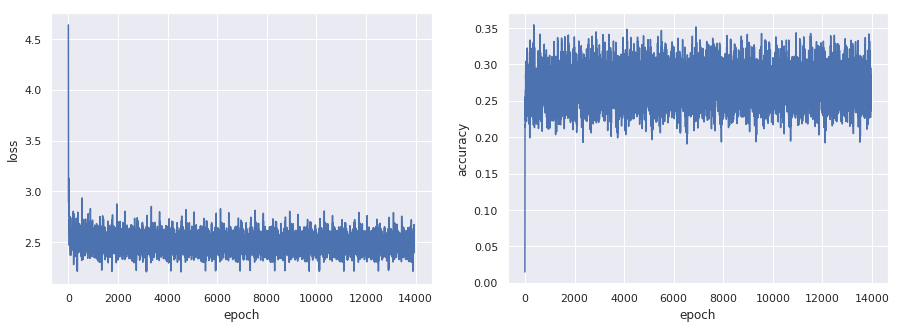

In [14]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()

In [15]:
print(''.join([idx2char[i] for i in sess.run(model.generate)]))

<start> the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 